## Challenge 2

The script takes a black-outline PNG of China and a CSV of numbers, then:

1. **Tells Python where the files live** (`ROOT`, `MAP_FN`, `CSV_FN`).






In [1]:
# ------------------------------------------------------------
#  Inputs   : china_map.png , china_map_values.csv
#  Outputs  : no_names_map.png , segmented_named_map.png
# ------------------------------------------------------------
from pathlib import Path
import cv2, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy import ndimage
from skimage import measure

ROOT   = Path(".")      
MAP_FN = ROOT / "china_map.png"
CSV_FN = ROOT / "china_map_values.csv"

2. **Hard-wires a mapping** from every region-ID in the segmented image to
   the correct province name (`label_to_province`).  
   *This guarantees each coloured blob is the right province—no guessing.*



In [2]:
# ------------------------------------------------------------
#  Define province labels
# ------------------------------------------------------------

label_to_province = {
     1: "Heilongjiang",
     2: "Inner Mongolia",
     3: "Xinjiang",
     5: "Liaoning",
     6: "Hebei",
     7: "Ningxia",
     9: "Beijing",
    11: "Shanxi",
    14: "Henan",
    17: "Gansu",
    18: "Shaanxi",
    23: "Tianjin",
    24: "Tibet",
    25: "Hubei",
    27: "Shandong",
    28: "Jiangsu",
    29: "Sichuan",
    31: "Hunan",
    39: "Zhejiang",
    42: "Jiangxi",
    43: "Fujian",
    47: "Guizhou",
    48: "Yunnan",
    49: "Guangdong",
    52: "Guangxi",
    53: "Shanghai",
    54: "Taiwan",     
    67: "Hainan",
}


3. **Reads the CSV**, trims whitespace, converts the “Mb 2005” column to
   floats, and stores it in a handy dictionary-like Pandas Series called
   `values`.


In [3]:

# ------------------------------------------------------------
#  Load CSV with values  (province  -> Mb 2005)
# ------------------------------------------------------------
df = pd.read_csv(CSV_FN)
df["Provinces"] = df["Provinces"].str.strip()
df["Mb 2005"]   = pd.to_numeric(df["Mb 2005"], errors="coerce")
values = df.set_index("Provinces")["Mb 2005"]      



4. **Segments the PNG**:  
   * Turns the map to greyscale → thresholds the black borders → fills
   holes → gives every province a unique integer label (1, 2, 3…).  


In [4]:

# ------------------------------------------------------------
#  Segment the PNG → labels array
# ------------------------------------------------------------
img  = cv2.imread(str(MAP_FN))
if img is None:
    raise FileNotFoundError(MAP_FN)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
border_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)[1]
land_mask   = ndimage.binary_fill_holes(border_mask).astype(bool) & (border_mask == 0)

labels, _ = measure.label(land_mask, connectivity=1, return_num=True)


5. **Paints the heat-map**:  
   * Looks up the Mb 2005 value for each province, normalises it between
   the CSV’s min & max, maps that 0-to-1 number onto a red→yellow colour
   scale, and flood-fills every pixel whose label matches.  
   * Draws crisp black borders back on top so provinces remain clear.



In [ ]:
# ------------------------------------------------------------
#  Build heat-map image
# ------------------------------------------------------------
h, w   = labels.shape
heat   = np.full((h, w, 3), 255, np.uint8)     # white background

# gather min/max for colour scale
vals = [values[p] for p in label_to_province.values() if p in values]
vmin, vmax = min(vals), max(vals)
cmap = LinearSegmentedColormap.from_list("red2yellow", ["red", "orange", "yellow"])

# paint each province region
for lab, province in label_to_province.items():
    if province not in values:
        continue                # skip if no data in CSV
    norm = (values[province] - vmin) / (vmax - vmin + 1e-9)
    r, g, b = cmap(norm)[:3]
    heat[labels == lab] = (int(b*255), int(g*255), int(r*255))  

# draw black borders on top
heat[border_mask > 0] = (0, 0, 0)
cv2.imwrite(str(ROOT / "no_names_map.png"), heat)


True

6. **Writes the province name** in the middle of each region (quick
   centroid of the pixels), skipping any province that’s missing from the
   CSV.



In [ ]:
# ------------------------------------------------------------
#  Add province names (text at centroid of each label)
# ------------------------------------------------------------
named = heat.copy()
for lab, province in label_to_province.items():
    if province not in values:
        continue
    ys, xs = np.where(labels == lab)
    if ys.size < 500:
        continue
    cx, cy = int(xs.mean()), int(ys.mean())
    cv2.putText(named, province, (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.35,
                (0, 0, 0), 1, cv2.LINE_AA)


7. **Displays & saves** two PNGs:  
   * `no_names_map.png` – colours only, no text.  
   * `segment_named_map.png` – colours **plus** names **plus** a vertical
   colour-bar that matches the exact data range.

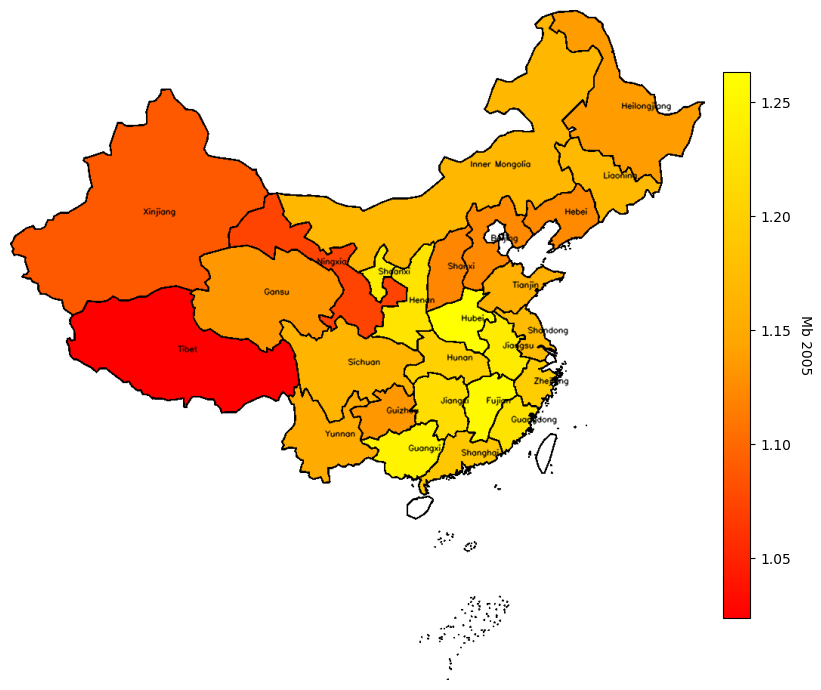

✅  Files written:
   • no_names_map.png
   • segment_named_map.png


In [7]:
# ------------------------------------------------------------
#  Show + save with colour-bar
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(cv2.cvtColor(named, cv2.COLOR_BGR2RGB))
ax.axis("off")

sm   = plt.cm.ScalarMappable(cmap=cmap,
                             norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Mb 2005", rotation=270, labelpad=15)

plt.tight_layout()
out_png = ROOT / "segment_named_map.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()

print("✅  Files written:")
print("   •", ROOT / "no_names_map.png")
print("   •", out_png)